# 1. Multi-Armed Bandit - Overview

An important challenge in many recommendation settings is that new users and items constantly appear in the system and it is important for the recommender system to constantly adapt to the changing patterns in the data. Therefore, unlike offline recommendation algorithms, the approach needs to simultaneously **explore** and **exploit** the search space of recommendations. The main challenge in these systems is that new users and new articles constantly enter the system; therefore, one must **simultaneously** **learn** the user interests and exploit these interests during the operation of the system.

![mab](img/mab-analogy.png)

The strategies correspond to the choices a user have. If we think of a the example of web pages, when a user clicks on the link of a recommended page, the recommender system receives a payoff in terms of the success of the recommendation. In the simplest case, the click-through problem is modeled with binary payoffs, where a click amounts to a payoff of $1$ unit.

In most practical settings, additional contextual information may be available to the recommender system about the user or the context of the recommendation. Some examples of such contextual information are as follows:
1. A set of features describing the profile of the user or the item-context may be available.
2. The users may be clustered into groups, and the cluster identifier of the group may be used as semantic knowledge about the user.

In cases where contextual information is available about the users, it is often assumed that user identification mechanisms are available.


## 1.1. A Naive MAB Environment

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Environment(object):
    def __init__(self, reward_probabilities, actual_rewards):
        if len(reward_probabilities) != len(actual_rewards):
            raise Exception(f"size of reward_probabilities : {len(reward_probabilities)} does not match size of actual rewards : {len(actual_rewards)}")

        self.reward_probabilities = reward_probabilities
        self.actual_rewards = actual_rewards
        self.k_arms = len(reward_probabilities)

    def choose_arm(self, arm):
        if arm < 0 or arm >= self.k_arms:
            raise Exception(f"arm must be between 0 and {self.k_arms -1}")

        return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [8]:
# Explore the probabilities generated
np.random.random()

0.7119540729047588

In [9]:
# Define an environment with rewards (i.e. payoffs) being 1 and random estimated reward probabilities
env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

# NOTE:
# - In real life, the model learns the reward probabilities

In [10]:
# Pull arm 1 for 10 times
[env.choose_arm(1) for _ in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [11]:
# Pull arm 2 for 10 times
[env.choose_arm(2) for _ in range(10)]

[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]

In [12]:
# Pull arm 0 for 10 times
[env.choose_arm(0) for _ in range(10)]

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]

## 1.2. Random Agent

In [13]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      # Randomly choosing arm; no exploitation of the environment
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}



In [14]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
random_agent = RandomAgent(test_env)
random_agent_result = random_agent.act()

total_rewards = sum(random_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 254.0


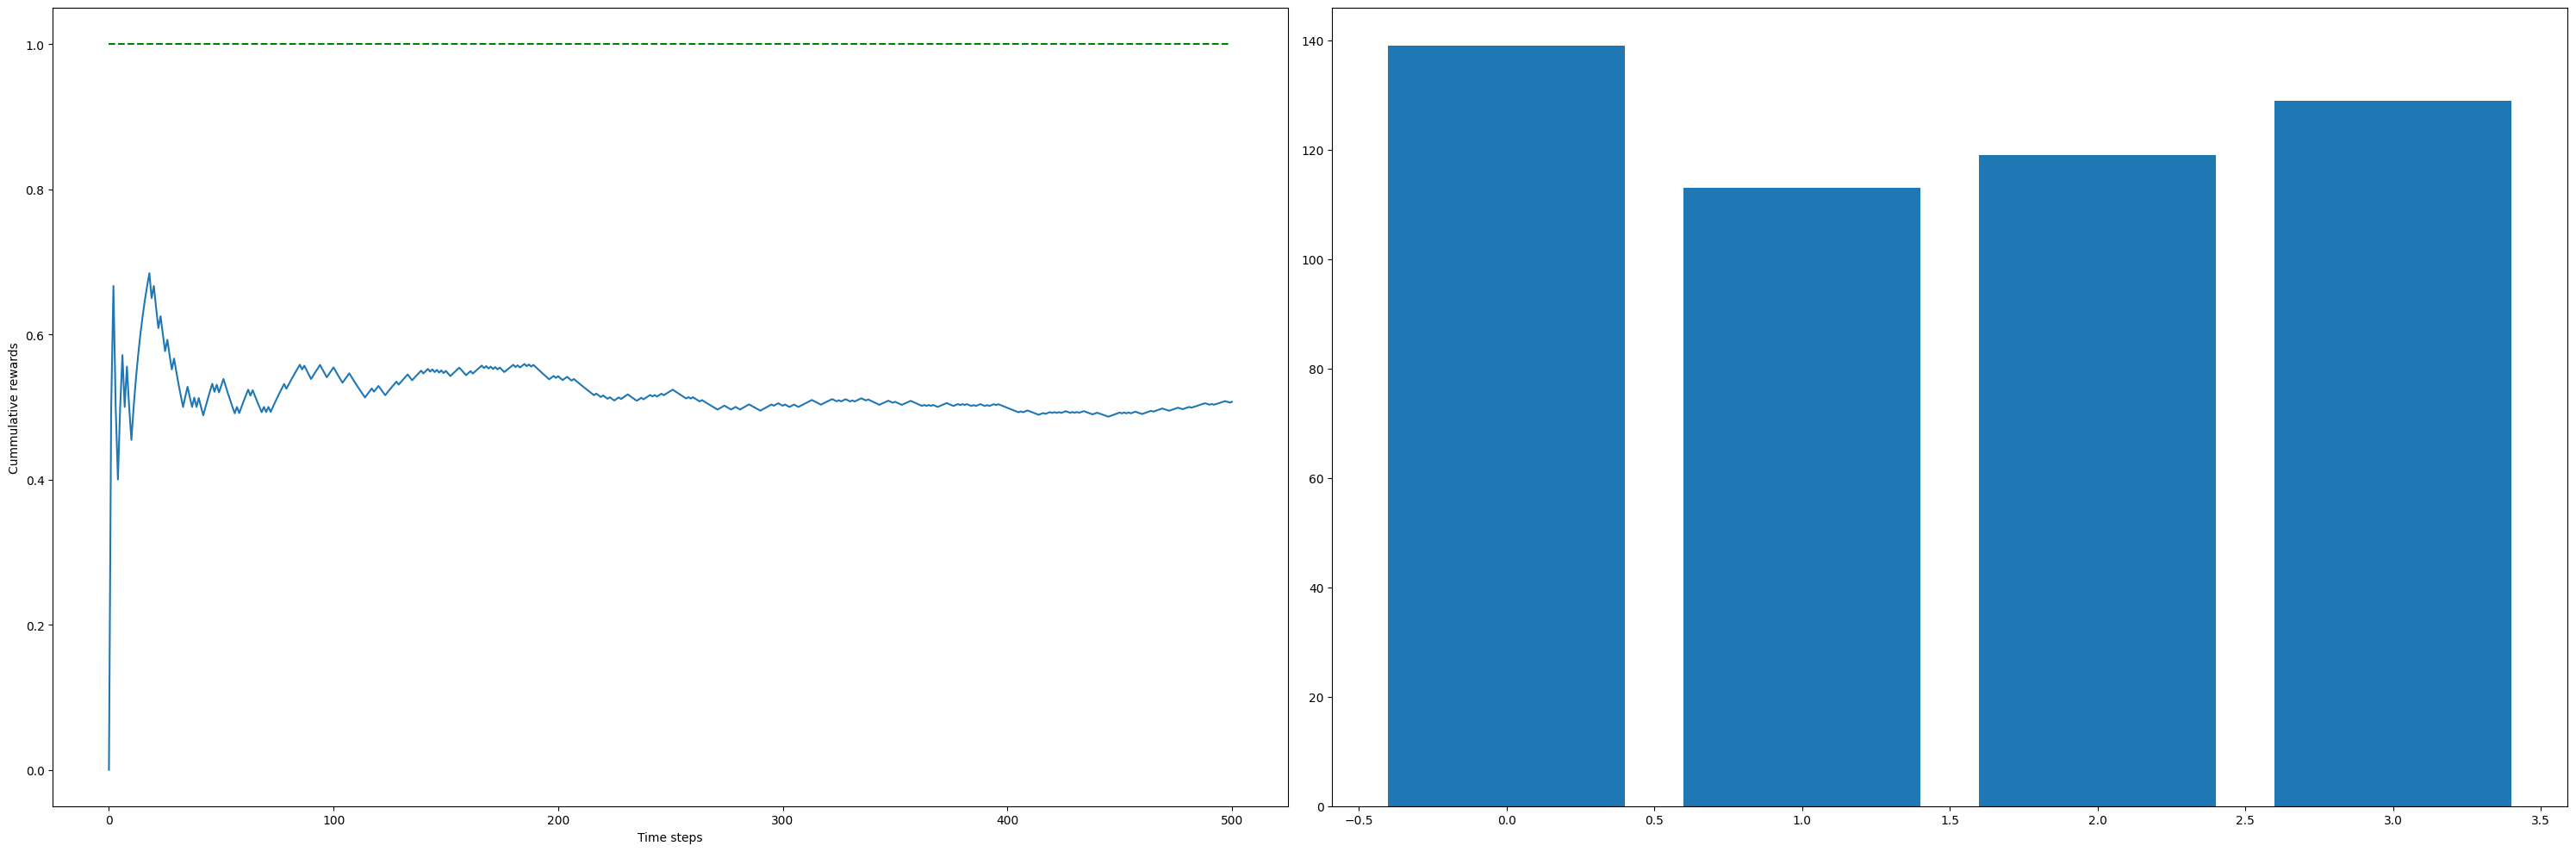

In [15]:
cum_rewards = random_agent_result["cum_rewards"]
arm_counts = random_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

## 1.3. A Greedy Agent

In [16]:
class GreedyAgent(object):

    def __init__(self, env, max_iterations=500):
        self.env = env
        self.iterations = max_iterations

        self.q_values = np.zeros(self.env.k_arms)
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for _ in range(self.iterations):
            arm = np.argmax(self.q_values)
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [17]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
greedy_agent = GreedyAgent(test_env)
greedy_agent_result = greedy_agent.act()

total_rewards = sum(greedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 314.0


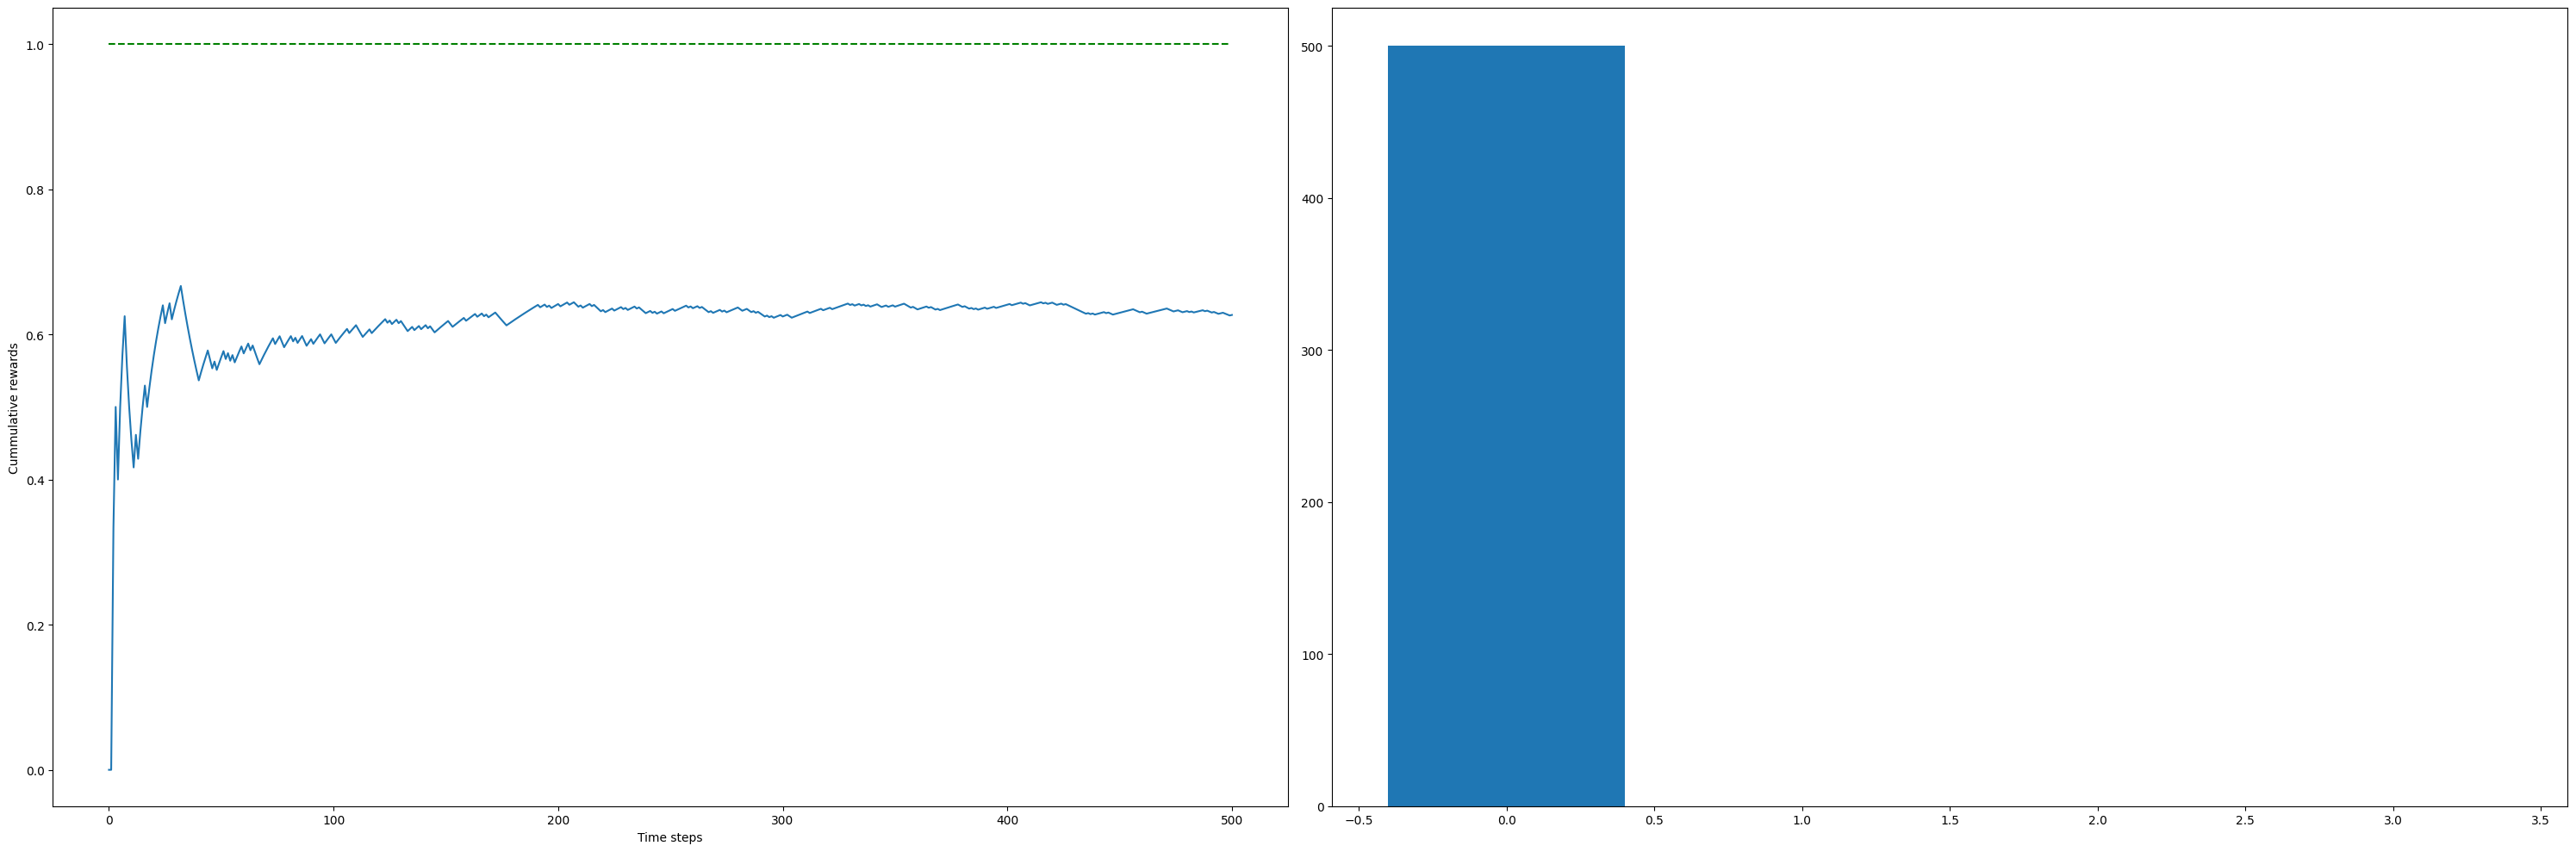

In [18]:
cum_rewards = greedy_agent_result["cum_rewards"]
arm_counts = greedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(greedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

In [19]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {greedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.628 0.    0.    0.   ]


## 1.3. ε-greedy Agent

In [51]:
class EpsilonGreedyAgent(object):

    def __init__(self, env, max_iterations=500, epsilon=0.01, decay_rate=0.01, decay_interval=50):
        self.env = env
        self.iterations = max_iterations
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.decay_interval = decay_interval

        self.q_values = np.zeros(self.env.k_arms)
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for i in range(self.iterations):
            arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(self.q_values)
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

            if i % self.decay_interval == 0:
                self.epsilon = self.epsilon * self.decay_rate

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [62]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
egreedy_agent = EpsilonGreedyAgent(test_env, epsilon=0.1, decay_rate=1.0, decay_interval=50)
egreedy_agent_result = egreedy_agent.act()

total_rewards = sum(egreedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 393.0


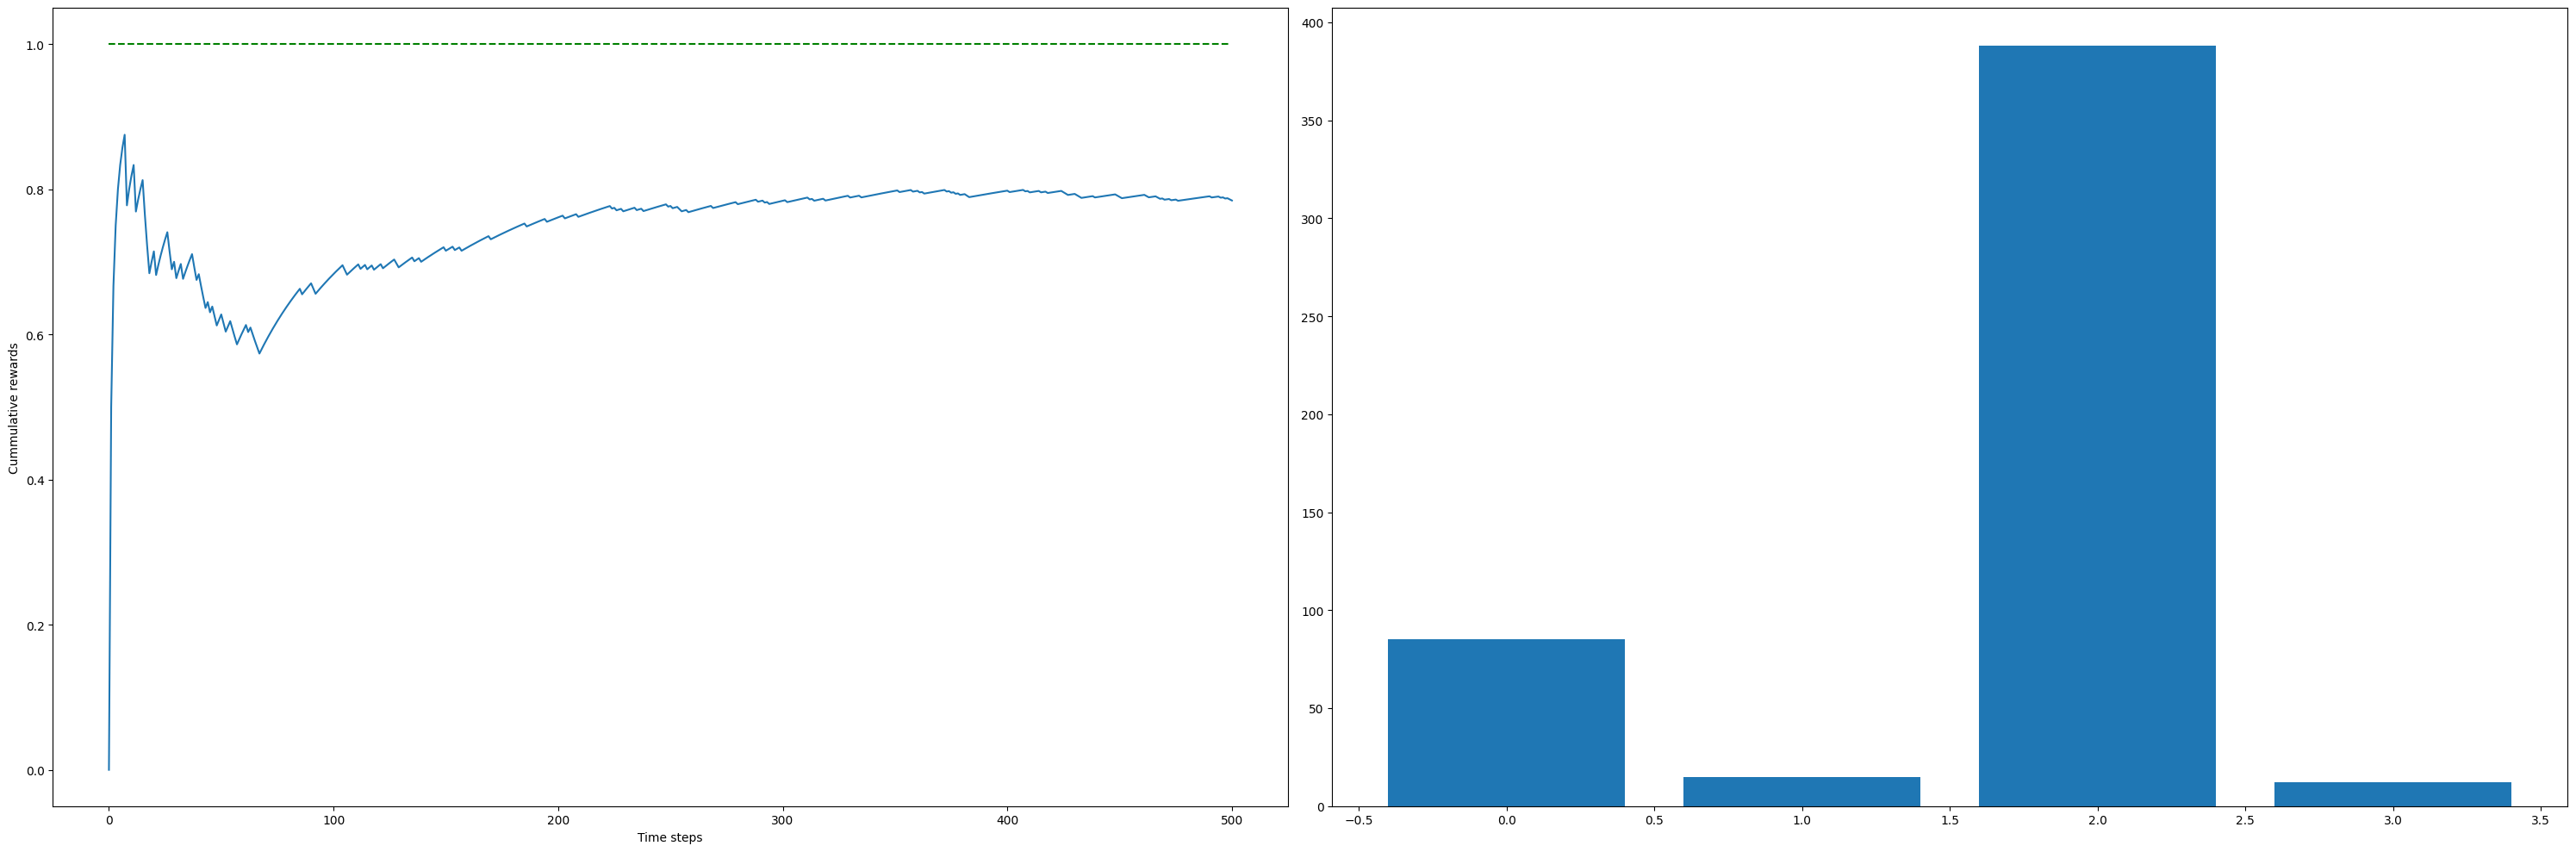

In [63]:
cum_rewards = egreedy_agent_result["cum_rewards"]
arm_counts = egreedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(egreedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

In [64]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {egreedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.65882353 0.         0.8556701  0.41666667]


## 1.3. Softmax/Boltzmann Distribution

All non-best actions (arms) were equivalently considered in the epsilon-greedy strategy but there should be a better way. Think of medical trials for a moment. Would you randomly pick non-best medications or you'll want to be better informed?

With the Softmax Exploration algorithm, actions are selected based on the Boltzmann Distribution with the formular below : 

$$
P(a_i) = \frac{e^{q_i / \tau}}{\sum_{j=1}^{k} e^{q_j / \tau}}
$$

where:
- $P(a_i)$ is the probability of selecting action $a_i$
- $q_i$ is the estimated value of action $a_i$
- $\tau$ is known as the temperature parameter that controls the exploration-exploitation trade-off
- $k$ is the number of actions (arms)

In [65]:
class SoftmaxExplorationAgent(object):

    def __init__(self, env, max_iterations=500, tau=0.5):
        self.env = env
        self.iterations = max_iterations
        self.tau = tau

        self.action_probas = np.zeros(self.env.k_arms)
        self.q_values = np.zeros(self.env.k_arms)
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for i in range(self.iterations):
            self.action_probas = np.exp(self.q_values/self.tau) / np.sum(np.exp(self.q_values/self.tau))
            arm = np.random.choice(self.env.k_arms, p=self.action_probas)
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [66]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
softmax_agent = SoftmaxExplorationAgent(test_env, tau=0.015, max_iterations=2000)
softmax_agent_result = softmax_agent.act()

total_rewards = sum(softmax_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 999.0


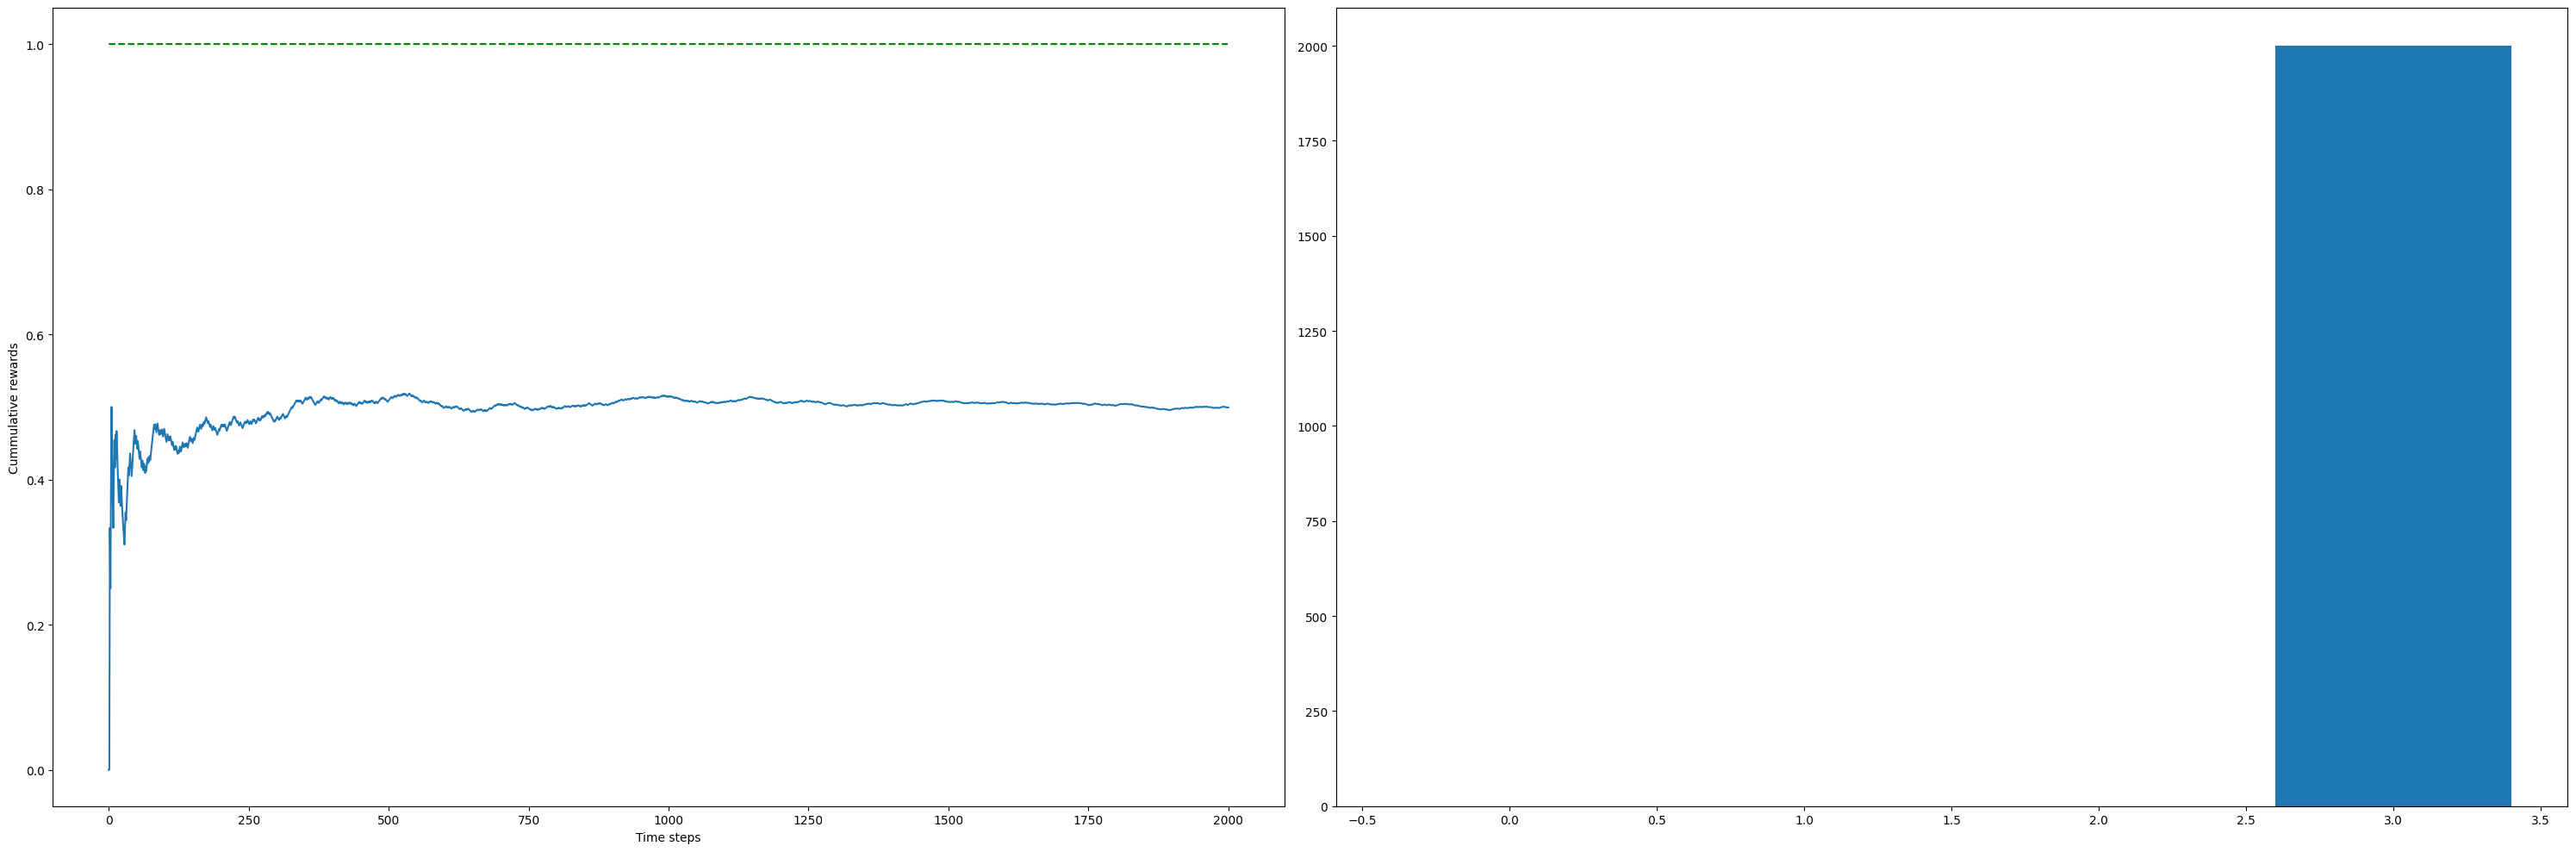

In [68]:
cum_rewards = softmax_agent_result["cum_rewards"]
arm_counts = softmax_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(softmax_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()